In [1]:
import pandas as pd
import numpy as np
import cobra
from Bio import SeqIO, Seq
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from cobra import Model, Reaction, Metabolite
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

In [ ]:
## import binary datasets

In [2]:
reaction_matrix = pd.read_csv("/home/users/lzehetner/data/hek/reaction_matrix.csv")

In [3]:
I_T_04 = ["lp_v1_tp2", "lp_v2_tp2", "lp_v3_tp2", "lp_v4_tp2"]
I_T_24 = ["lp_v1_tp3", "lp_v2_tp3", "lp_v3_tp3", "lp_v4_tp3"]
I_T_48 = ["lp_v1_tp4", "lp_v2_tp4", "lp_v3_tp4", "lp_v4_tp4"]
I_T_72 = ["lp_v1_tp5", "lp_v2_tp5", "lp_v3_tp5", "lp_v4_tp5"]

I_M_04 = ["lp_v5_tp2", "lp_v6_tp2", "lp_v7_tp2", "lp_v8_tp2"]
I_M_24 = ["lp_v5_tp3", "lp_v6_tp3", "lp_v7_tp3", "lp_v8_tp3"]
I_M_48 = ["lp_v5_tp4", "lp_v6_tp4", "lp_v7_tp4", "lp_v8_tp4"]
I_M_72 = ["lp_v5_tp5", "lp_v6_tp5", "lp_v7_tp5", "lp_v8_tp5"]

P_T_04 = ["hp_v1_tp2", "hp_v2_tp2", "hp_v3_tp2", "hp_v4_tp2"]
P_T_24 = ["hp_v1_tp3", "hp_v2_tp3", "hp_v3_tp3", "hp_v4_tp3"]
P_T_48 = ["hp_v1_tp4", "hp_v2_tp4", "hp_v3_tp4", "hp_v4_tp4"]
P_T_72 = ["hp_v1_tp5", "hp_v2_tp5", "hp_v3_tp5", "hp_v4_tp5"]

P_M_04 = ["hp_v5_tp2", "hp_v6_tp2", "hp_v7_tp2", "hp_v8_tp2"]
P_M_24 = ["hp_v5_tp3", "hp_v6_tp3", "hp_v7_tp3", "hp_v8_tp3"]
P_M_48 = ["hp_v5_tp4", "hp_v6_tp4", "hp_v7_tp4", "hp_v8_tp4"]
P_M_72 = ["hp_v5_tp5", "hp_v6_tp5", "hp_v8_tp5"]

In [4]:
input_rates = "/home/users/lzehetner/data/hek/specific_exchange_rates.csv"
df = pd.read_csv(input_rates)

In [5]:
filtered_dfs = {}

In [6]:
states = ['HP_TR', 'HP_MO', 'LP_TR', 'LP_MO']
time_points = [4, 24, 48, 72]

In [7]:
for state in states:
    for time_point in time_points:
        key = f"{state}_{time_point}"
        filtered_dfs[key] = df[(df['state'] == state) & (df['time_point'] == time_point)]

In [8]:
df_hp_tr_4 = filtered_dfs['HP_TR_4']
df_hp_tr_24 = filtered_dfs['HP_TR_24']
df_hp_tr_48 = filtered_dfs['HP_TR_48']
df_hp_tr_72 = filtered_dfs['HP_TR_72']

df_hp_mo_4 = filtered_dfs['HP_MO_4']
df_hp_mo_24 = filtered_dfs['HP_MO_24']
df_hp_mo_48 = filtered_dfs['HP_MO_48']
df_hp_mo_72 = filtered_dfs['HP_MO_72']

df_lp_tr_4 = filtered_dfs['LP_TR_4']
df_lp_tr_24 = filtered_dfs['LP_TR_24']
df_lp_tr_48 = filtered_dfs['LP_TR_48']
df_lp_tr_72 = filtered_dfs['LP_TR_72']

df_lp_mo_4 = filtered_dfs['LP_MO_4']
df_lp_mo_24 = filtered_dfs['LP_MO_24']
df_lp_mo_48 = filtered_dfs['LP_MO_48']
df_lp_mo_72 = filtered_dfs['LP_MO_72']

In [9]:
# remove last row with ammonia, since there are no exchange rate fitted
df_hp_tr_72 = df_hp_tr_72[:-1]

In [10]:
metabolite_to_reaction = {'Alanine': 'MAR09061',
                         'Arginine': 'MAR09066',
                         'Asparagine': 'MAR09062',
                         'Aspartic acid': 'MAR09070',
                         'Glutamate': 'MAR09071',
                         'Glutamine': 'MAR09063',
                         'Gly': 'MAR09067',
                         'Histidine': 'MAR09038',
                         'Isoleucine': 'MAR09039',
                         'Leucine': 'MAR09040',
                         'Lysine': 'MAR09041',
                         'Methionine': 'MAR09042',
                         'Phenylalanine': 'MAR09043',
                         'Pro': 'MAR09068',
                         'Serine': 'MAR09069',
                         'Threonine': 'MAR09044',
                         'Tryptophan': 'MAR09045',
                         'Tyrosine': 'MAR09064',
                         'Valine': 'MAR09046',
                         'Glucose': 'MAR09034',
                         'Nh3': 'MAR11420',
                         'Lac': 'MAR09135'
                         }

In [11]:
input_model = "/home/users/lzehetner/data/human1/human1.xml"
mod = cobra.io.read_sbml_model(input_model)
mod.solver = "cplex"

In [12]:
min_media_comp = [
    "MAR09061",
    "MAR09034",
    "MAR09035",
    "MAR09036",
    "MAR09038",
    "MAR09039",
    "MAR09040",
    "MAR09041",
    "MAR09042",
    "MAR09043",
    "MAR09044",
    "MAR09045",
    "MAR09046",
    "MAR09047",
    "MAR09048",
    "MAR09062",
    "MAR09063",
    "MAR09064",
    "MAR09065",
    "MAR09066",
    "MAR09068",
    "MAR09069",
    "MAR09076",
    "MAR09146",
    "MAR09109",
    "MAR09143",
    "MAR09144",
    "MAR09147",
    "MAR09150",
    "MAR09151",
    "MAR09153",
    "MAR09158",
    "MAR09159",
    "MAR09167",
    "MAR09269",
    "MAR09072",
    "MAR09145",
    "MAR09070",
    "MAR09071",
    "MAR09067",
    "MAR11420",
    "MAR09135"
]

In [ ]:
## AAV production reaction

In [13]:
##### Alanine reaction

ala_reaction = Reaction('MAR_ALA_nuc')
ala_reaction.name = 'Exchange reaction of alanine between cytosole and nucleus'
ala_reaction.subsystem = ''
ala_reaction.lower_bound = 0 # but needs to be adopted from paper
ala_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01307n = Metabolite(
    'MAM01307n',
    formula= mod.metabolites.get_by_id("MAM01307c").formula,
    name='alanine',
    compartment='n')

ala_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01307c"): -1, # Alanine
    MAM01307n: 1
})

##### Arginine reaction

arg_reaction = Reaction('MAR_ARG_nuc')
arg_reaction.name = 'Exchange reaction of arginine between cytosole and nucleus'
arg_reaction.subsystem = ''
arg_reaction.lower_bound = 0 # but needs to be adopted from paper
arg_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01365n = Metabolite(
    'MAM01365n',
    formula= mod.metabolites.get_by_id("MAM01365c").formula,
    name='arginine',
    compartment='n')

arg_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01365c"): -1, # Alanine
    MAM01365n: 1
})

##### Asparagine reaction

asn_reaction = Reaction('MAR_ASN_nuc')
asn_reaction.name = 'Exchange reaction of asparagine between cytosole and nucleus'
asn_reaction.subsystem = ''
asn_reaction.lower_bound = 0 # but needs to be adopted from paper
asn_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01369n = Metabolite(
    'MAM01369n',
    formula= mod.metabolites.get_by_id("MAM01369c").formula,
    name='asparagine',
    compartment='n')

asn_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01369c"): -1, # Alanine
    MAM01369n: 1
})

##### Aspartate reaction

asp_reaction = Reaction('MAR_ASP_nuc')
asp_reaction.name = 'Exchange reaction of aspartate between cytosole and nucleus'
asp_reaction.subsystem = ''
asp_reaction.lower_bound = 0 # but needs to be adopted from paper
asp_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01370n = Metabolite(
    'MAM01370n',
    formula= mod.metabolites.get_by_id("MAM01370c").formula,
    name='aspartate',
    compartment='n')

asp_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01370c"): -1, # Alanine
    MAM01370n: 1
})

##### Cysteine reaction

cys_reaction = Reaction('MAR_CYS_nuc')
cys_reaction.name = 'Exchange reaction of cysteine between cytosole and nucleus'
cys_reaction.subsystem = ''
cys_reaction.lower_bound = 0 # but needs to be adopted from paper
cys_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01628n = Metabolite(
    'MAM01628n',
    formula= mod.metabolites.get_by_id("MAM01628c").formula,
    name='cysteine',
    compartment='n')

cys_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01628c"): -1, # Alanine
    MAM01628n: 1
})

##### Glutamine reaction

gln_reaction = Reaction('MAR_GLN_nuc')
gln_reaction.name = 'Exchange reaction of glutamine between cytosole and nucleus'
gln_reaction.subsystem = ''
gln_reaction.lower_bound = 0 # but needs to be adopted from paper
gln_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01975n = Metabolite(
    'MAM01975n',
    formula= mod.metabolites.get_by_id("MAM01975c").formula,
    name='glutamine',
    compartment='n')

gln_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01975c"): -1, # Alanine
    MAM01975n: 1
})

##### Glutamate reaction

glu_reaction = Reaction('MAR_GLU_nuc')
glu_reaction.name = 'Exchange reaction of glutamate between cytosole and nucleus'
glu_reaction.subsystem = ''
glu_reaction.lower_bound = 0 # but needs to be adopted from paper
glu_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01974n = Metabolite(
    'MAM01974n',
    formula= mod.metabolites.get_by_id("MAM01974c").formula,
    name='glutamate',
    compartment='n')

glu_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01974c"): -1, # Alanine
    MAM01974n: 1
})

##### Glycine reaction

gly_reaction = Reaction('MAR_GLY_nuc')
gly_reaction.name = 'Exchange reaction of glycine between cytosole and nucleus'
gly_reaction.subsystem = ''
gly_reaction.lower_bound = 0 # but needs to be adopted from paper
gly_reaction.upper_bound = 1000 # but needs also to be adopted

MAM01986n = Metabolite(
    'MAM01986n',
    formula= mod.metabolites.get_by_id("MAM01986c").formula,
    name='glycine',
    compartment='n')

gly_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01986c"): -1, # Alanine
    MAM01986n: 1
})

##### Histidine reaction

his_reaction = Reaction('MAR_HIS_nuc')
his_reaction.name = 'Exchange reaction of histidine between cytosole and nucleus'
his_reaction.subsystem = ''
his_reaction.lower_bound = 0 # but needs to be adopted from paper
his_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02125n = Metabolite(
    'MAM02125n',
    formula= mod.metabolites.get_by_id("MAM02125c").formula,
    name='histidine',
    compartment='n')

his_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02125c"): -1, # Alanine
    MAM02125n: 1
})

##### Isoleucine reaction

ile_reaction = Reaction('MAR_ILE_nuc')
ile_reaction.name = 'Exchange reaction of isoleucine between cytosole and nucleus'
ile_reaction.subsystem = ''
ile_reaction.lower_bound = 0 # but needs to be adopted from paper
ile_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02184n = Metabolite(
    'MAM02184n',
    formula= mod.metabolites.get_by_id("MAM02184c").formula,
    name='isoleucine',
    compartment='n')

ile_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02184c"): -1, # Alanine
    MAM02184n: 1
})

##### Leucine reaction

leu_reaction = Reaction('MAR_LEU_nuc')
leu_reaction.name = 'Exchange reaction of leucine between cytosole and nucleus'
leu_reaction.subsystem = ''
leu_reaction.lower_bound = 0 # but needs to be adopted from paper
leu_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02360n = Metabolite(
    'MAM02360n',
    formula= mod.metabolites.get_by_id("MAM02360c").formula,
    name='leucine',
    compartment='n')

leu_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02360c"): -1, # Alanine
    MAM02360n: 1
})

##### Lysine reaction

lys_reaction = Reaction('MAR_LYS_nuc')
lys_reaction.name = 'Exchange reaction of lysine between cytosole and nucleus'
lys_reaction.subsystem = ''
lys_reaction.lower_bound = 0 # but needs to be adopted from paper
lys_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02426n = Metabolite(
    'MAM02426n',
    formula= mod.metabolites.get_by_id("MAM02426c").formula,
    name='lysine',
    compartment='n')

lys_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02426c"): -1,
    MAM02426n: 1
})

##### Methionine reaction

met_reaction = Reaction('MAR_MET_nuc')
met_reaction.name = 'Exchange reaction of methionine between cytosole and nucleus'
met_reaction.subsystem = ''
met_reaction.lower_bound = 0 # but needs to be adopted from paper
met_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02471n = Metabolite(
    'MAM02471n',
    formula= mod.metabolites.get_by_id("MAM02471c").formula,
    name='methionine',
    compartment='n')

met_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02471c"): -1,
    MAM02471n: 1
})

##### Phenylalanine reaction

phe_reaction = Reaction('MAR_PHE_nuc')
phe_reaction.name = 'Exchange reaction of phenylalanine between cytosole and nucleus'
phe_reaction.subsystem = ''
phe_reaction.lower_bound = 0 # but needs to be adopted from paper
phe_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02724n = Metabolite(
    'MAM02724n',
    formula= mod.metabolites.get_by_id("MAM02724c").formula,
    name='phenylalanine',
    compartment='n')

phe_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02724c"): -1,
    MAM02724n: 1
})

##### Proline reaction

pro_reaction = Reaction('MAR_PRO_nuc')
pro_reaction.name = 'Exchange reaction of proline between cytosole and nucleus'
pro_reaction.subsystem = ''
pro_reaction.lower_bound = 0 # but needs to be adopted from paper
pro_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02770n = Metabolite(
    'MAM02770n',
    formula= mod.metabolites.get_by_id("MAM02770c").formula,
    name='proline',
    compartment='n')

pro_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02770c"): -1,
    MAM02770n: 1
})

##### Serine reaction

ser_reaction = Reaction('MAR_SER_nuc')
ser_reaction.name = 'Exchange reaction of serine between cytosole and nucleus'
ser_reaction.subsystem = ''
ser_reaction.lower_bound = 0 # but needs to be adopted from paper
ser_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02896n = Metabolite(
    'MAM02896n',
    formula= mod.metabolites.get_by_id("MAM02896c").formula,
    name='serine',
    compartment='n')

ser_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02896c"): -1,
    MAM02896n: 1
})

##### Threonine reaction

thr_reaction = Reaction('MAR_THR_nuc')
thr_reaction.name = 'Exchange reaction of threonine between cytosole and nucleus'
thr_reaction.subsystem = ''
thr_reaction.lower_bound = 0 # but needs to be adopted from paper
thr_reaction.upper_bound = 1000 # but needs also to be adopted

MAM02993n = Metabolite(
    'MAM02993n',
    formula= mod.metabolites.get_by_id("MAM02993c").formula,
    name='threonine',
    compartment='n')

thr_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM02993c"): -1,
    MAM02993n: 1
})

##### Tryptophane reaction

trp_reaction = Reaction('MAR_TRP_nuc')
trp_reaction.name = 'Exchange reaction of tryptophane between cytosole and nucleus'
trp_reaction.subsystem = ''
trp_reaction.lower_bound = 0 # but needs to be adopted from paper
trp_reaction.upper_bound = 1000 # but needs also to be adopted

MAM03089n = Metabolite(
    'MAM03089n',
    formula= mod.metabolites.get_by_id("MAM03089c").formula,
    name='tryptophane',
    compartment='n')

trp_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM03089c"): -1,
    MAM03089n: 1
})

##### Tyrosine reaction

tyr_reaction = Reaction('MAR_TYR_nuc')
tyr_reaction.name = 'Exchange reaction of tyrosine between cytosole and nucleus'
tyr_reaction.subsystem = ''
tyr_reaction.lower_bound = 0 # but needs to be adopted from paper
tyr_reaction.upper_bound = 1000 # but needs also to be adopted

MAM03101n = Metabolite(
    'MAM03101n',
    formula= mod.metabolites.get_by_id("MAM03101c").formula,
    name='tyrosine',
    compartment='n')

tyr_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM03101c"): -1,
    MAM03101n: 1
})

##### Valine reaction

val_reaction = Reaction('MAR_VAL_nuc')
val_reaction.name = 'Exchange reaction of valine between cytosole and nucleus'
val_reaction.subsystem = ''
val_reaction.lower_bound = 0 # but needs to be adopted from paper
val_reaction.upper_bound = 1000 # but needs also to be adopted

MAM03135n = Metabolite(
    'MAM03135n',
    formula= mod.metabolites.get_by_id("MAM03135c").formula,
    name='valine',
    compartment='n')

val_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM03135c"): -1,
    MAM03135n: 1
})

In [14]:
# the file was downloaded from ncbi db
infile = open("/home/users/lzehetner/sequence_1.fasta")

aav_dict = SeqIO.to_dict(SeqIO.parse(infile, "fasta"))
# print(aav_dict)
vp1_seq = aav_dict["YP_077180.1"].seq
vp2_seq = aav_dict["YP_077180.2"].seq
vp3_seq = aav_dict["YP_077180.3"].seq

In [15]:
vp1_counts = {
    "A": vp1_seq.count('A'),
    "R": vp1_seq.count('R'),
    "N": vp1_seq.count('N'),
    "D": vp1_seq.count('D'),
    "C": vp1_seq.count('C'),
    "Q": vp1_seq.count('Q'),
    "E": vp1_seq.count('E'),
    "G": vp1_seq.count('G'),
    "H": vp1_seq.count('H'),
    "I": vp1_seq.count('I'),
    "L": vp1_seq.count('L'),
    "K": vp1_seq.count('K'),
    "M": vp1_seq.count('M'),
    "F": vp1_seq.count('F'),
    "P": vp1_seq.count('P'),
    "S": vp1_seq.count('S'),
    "T": vp1_seq.count('T'),
    "W": vp1_seq.count('W'),
    "Y": vp1_seq.count('Y'),
    "V": vp1_seq.count('V'),
}

vp2_counts = {
    "A": vp2_seq.count('A'),
    "R": vp2_seq.count('R'),
    "N": vp2_seq.count('N'),
    "D": vp2_seq.count('D'),
    "C": vp2_seq.count('C'),
    "Q": vp2_seq.count('Q'),
    "E": vp2_seq.count('E'),
    "G": vp2_seq.count('G'),
    "H": vp2_seq.count('H'),
    "I": vp2_seq.count('I'),
    "L": vp2_seq.count('L'),
    "K": vp2_seq.count('K'),
    "M": vp2_seq.count('M'),
    "F": vp2_seq.count('F'),
    "P": vp2_seq.count('P'),
    "S": vp2_seq.count('S'),
    "T": vp2_seq.count('T'),
    "W": vp2_seq.count('W'),
    "Y": vp2_seq.count('Y'),
    "V": vp2_seq.count('V'),
}

vp3_counts = {
    "A": vp3_seq.count('A'),
    "R": vp3_seq.count('R'),
    "N": vp3_seq.count('N'),
    "D": vp3_seq.count('D'),
    "C": vp3_seq.count('C'),
    "Q": vp3_seq.count('Q'),
    "E": vp3_seq.count('E'),
    "G": vp3_seq.count('G'),
    "H": vp3_seq.count('H'),
    "I": vp3_seq.count('I'),
    "L": vp3_seq.count('L'),
    "K": vp3_seq.count('K'),
    "M": vp3_seq.count('M'),
    "F": vp3_seq.count('F'),
    "P": vp3_seq.count('P'),
    "S": vp3_seq.count('S'),
    "T": vp3_seq.count('T'),
    "W": vp3_seq.count('W'),
    "Y": vp3_seq.count('Y'),
    "V": vp3_seq.count('V'),
}

print("VP1: ", vp1_counts)
print("VP2: ", vp2_counts)
print("VP3: ", vp3_counts)

VP1:  {'A': 51, 'R': 31, 'N': 58, 'D': 37, 'C': 5, 'Q': 48, 'E': 34, 'G': 69, 'H': 14, 'I': 24, 'L': 53, 'K': 32, 'M': 11, 'F': 32, 'P': 57, 'S': 49, 'T': 55, 'W': 15, 'Y': 33, 'V': 30}
VP2:  {'A': 34, 'R': 25, 'N': 51, 'D': 25, 'C': 5, 'Q': 39, 'E': 23, 'G': 54, 'H': 12, 'I': 23, 'L': 37, 'K': 22, 'M': 10, 'F': 28, 'P': 48, 'S': 47, 'T': 54, 'W': 12, 'Y': 27, 'V': 25}
VP3:  {'A': 30, 'R': 21, 'N': 49, 'D': 22, 'C': 5, 'Q': 34, 'E': 20, 'G': 45, 'H': 12, 'I': 22, 'L': 35, 'K': 17, 'M': 10, 'F': 27, 'P': 35, 'S': 40, 'T': 50, 'W': 12, 'Y': 27, 'V': 22}


In [16]:
aa_compositions = {
    'A': {'C': 3, 'H': 7, 'O': 2, 'N': 1, 'S': 0},
    'C': {'C': 3, 'H': 7, 'O': 2, 'N': 1, 'S': 1},
    'D': {'C': 4, 'H': 7, 'O': 4, 'N': 1, 'S': 0},
    'E': {'C': 5, 'H': 9, 'O': 4, 'N': 1, 'S': 0},
    'F': {'C': 9, 'H': 11, 'O': 2, 'N': 1, 'S': 0},
    'G': {'C': 2, 'H': 5, 'O': 2, 'N': 1, 'S': 0},
    'H': {'C': 6, 'H': 9, 'O': 2, 'N': 3, 'S': 0},
    'I': {'C': 6, 'H': 13,'O': 2, 'N': 1, 'S': 0},
    'K': {'C': 6, 'H': 14,'O': 2, 'N': 2, 'S': 0},
    'L': {'C': 6, 'H': 13,'O': 2, 'N': 1, 'S': 0},
    'M': {'C': 5, 'H': 11, 'O': 2, 'N': 1, 'S': 1},
    'N': {'C': 4, 'H': 8, 'O': 3, 'N': 2, 'S': 0},
    'P': {'C': 5, 'H': 9, 'O': 2, 'N': 1, 'S': 0},
    'Q': {'C': 5, 'H': 10, 'O': 3, 'N': 2, 'S': 0},
    'R': {'C': 6, 'H': 14,'O': 2, 'N': 4, 'S': 0},
    'S': {'C': 3, 'H': 7, 'O': 3, 'N': 1, 'S': 0},
    'T': {'C': 4, 'H': 9, 'O': 3, 'N': 1, 'S': 0},
    'V': {'C': 5, 'H': 11, 'O': 2, 'N': 1, 'S': 0},
    'W': {'C': 11,'H': 12,'O': 2, 'N': 2, 'S': 0},
    'Y': {'C': 9, 'H': 11, 'O': 3, 'N': 1, 'S': 0},
}

# VP1
protein_seq = str(vp1_seq)
analysis = ProteinAnalysis(protein_seq)

# Count amino acids in the protein sequence
aa_counts = analysis.count_amino_acids()

# Calculate the sum formula based on atomic composition
sum_formula_counts = {'C': 0, 'H': 0, 'O': 0, 'N': 0, 'S': 0}

for aa, count in aa_counts.items():
    for atom, atom_count in aa_compositions[aa].items():
        sum_formula_counts[atom] += atom_count * count

# Adjust for the released water molecules during peptide bond formation
num_peptide_bonds = len(protein_seq) - 1
sum_formula_counts['H'] -= 2 * num_peptide_bonds
sum_formula_counts['O'] -= num_peptide_bonds

# Create the sum formula string
sum_formula_vp1 = "".join([f"{atom}{count}" for atom, count in sum_formula_counts.items()])
print(f"Sum Formula: {sum_formula_vp1}")

# VP2
protein_seq = str(vp2_seq)
analysis = ProteinAnalysis(protein_seq)

# Count amino acids in the protein sequence
aa_counts = analysis.count_amino_acids()

# Calculate the sum formula based on atomic composition
sum_formula_counts = {'C': 0, 'H': 0, 'O': 0, 'N': 0, 'S': 0}

for aa, count in aa_counts.items():
    for atom, atom_count in aa_compositions[aa].items():
        sum_formula_counts[atom] += atom_count * count

# Adjust for the released water molecules during peptide bond formation
num_peptide_bonds = len(protein_seq) - 1
sum_formula_counts['H'] -= 2 * num_peptide_bonds
sum_formula_counts['O'] -= num_peptide_bonds

# Create the sum formula string
sum_formula_vp2 = "".join([f"{atom}{count}" for atom, count in sum_formula_counts.items()])
print(f"Sum Formula: {sum_formula_vp2}")

# VP3
protein_seq = str(vp3_seq)
analysis = ProteinAnalysis(protein_seq)

# Count amino acids in the protein sequence
aa_counts = analysis.count_amino_acids()

# Calculate the sum formula based on atomic composition
sum_formula_counts = {'C': 0, 'H': 0, 'O': 0, 'N': 0, 'S': 0}

for aa, count in aa_counts.items():
    for atom, atom_count in aa_compositions[aa].items():
        sum_formula_counts[atom] += atom_count * count

# Adjust for the released water molecules during peptide bond formation
num_peptide_bonds = len(protein_seq) - 1
sum_formula_counts['H'] -= 2 * num_peptide_bonds
sum_formula_counts['O'] -= num_peptide_bonds

# Create the sum formula string
sum_formula_vp3 = "".join([f"{atom}{count}" for atom, count in sum_formula_counts.items()])
print(f"Sum Formula: {sum_formula_vp3}")




protein_seq = 5 * str(vp1_seq) + 5 * str(vp2_seq) + 50 * str(vp3_seq)
analysis = ProteinAnalysis(protein_seq)

# Count amino acids in the protein sequence
aa_counts = analysis.count_amino_acids()

# Calculate the sum formula based on atomic composition
sum_formula_counts = {'C': 0, 'H': 0, 'O': 0, 'N': 0, 'S': 0}

for aa, count in aa_counts.items():
    for atom, atom_count in aa_compositions[aa].items():
        sum_formula_counts[atom] += atom_count * count

# Adjust for the released water molecules during peptide bond formation
num_peptide_bonds = len(protein_seq) - 1
sum_formula_counts['H'] -= 2 * num_peptide_bonds
sum_formula_counts['O'] -= num_peptide_bonds

# Create the sum formula string
sum_formula_capsid = "".join([f"{atom}{count}" for atom, count in sum_formula_counts.items()])
print(f"Sum Formula of Capsid: {sum_formula_capsid}")


Sum Formula: C3627H5478O1124N1012S16
Sum Formula: C2952H4450O916N824S15
Sum Formula: C2664H3984O820N734S15
Sum Formula of Capsid: C166095H248722O51141N45880S905


In [17]:
##### vp1 reaction

vp1_reaction = Reaction('MAR_VP1')
vp1_reaction.name = 'Synthesis of viral protein 1'
vp1_reaction.subsystem = ''
vp1_reaction.lower_bound = 0 # but needs to be adopted from paper
vp1_reaction.upper_bound = 1000 # but needs also to be adopted

VP1_n = Metabolite(
    'VP1_n',
    formula= {sum_formula_vp1},
    name='Viral Protein 1',
    compartment='n')

vp1_reaction.add_metabolites({
    MAM01307n: -vp1_counts["A"], # Alanine
    MAM01365n: -vp1_counts["R"], # Arginine
    MAM01369n: -vp1_counts["N"], # Asparagine
    MAM01370n: -vp1_counts["D"], # Aspartate
    MAM01628n: -vp1_counts["C"], # Cysteine
    MAM01975n: -vp1_counts["Q"], # Glutamine
    MAM01974n: -vp1_counts["E"], # Glutamate
    MAM01986n: -vp1_counts["G"], # Glycine
    MAM02125n: -vp1_counts["H"], # Histidine
    MAM02184n: -vp1_counts["I"], # Ile
    MAM02360n: -vp1_counts["L"], # Leu
    MAM02426n: -vp1_counts["K"], # Lysin
    MAM02471n: -vp1_counts["M"], # Met
    MAM02724n: -vp1_counts["F"], # Phe
    MAM02770n: -vp1_counts["P"], # Pro
    MAM02896n: -vp1_counts["S"], # Serin
    MAM02993n: -vp1_counts["T"], # Thr
    MAM03089n: -vp1_counts["W"], # Trp
    MAM03101n: -vp1_counts["Y"], # Tyr
    MAM03135n: -vp1_counts["V"], # Val
    mod.metabolites.get_by_id("MAM02034n"): - 3 * sum(vp1_counts.values()), # GTP
    mod.metabolites.get_by_id("MAM02040n"): -( 3 * sum(vp1_counts.values()) + 1), # Water
    mod.metabolites.get_by_id("MAM01948n"): 3 * sum(vp1_counts.values()), # GDP
    mod.metabolites.get_by_id("MAM02751n"): 3 * sum(vp1_counts.values()), # phosphate
    mod.metabolites.get_by_id("MAM02039n"): 0.75 * 3 * sum(vp1_counts.values()), # proton
    VP1_n: 1.0
})

In [18]:
##### vp2 reaction
vp2_reaction = Reaction('MAR_VP2')
vp2_reaction.name = 'Synthesis of viral protein 2'
vp2_reaction.subsystem = ''
vp2_reaction.lower_bound = 0 # but needs to be adopted from paper
vp2_reaction.upper_bound = 1000 # but needs also to be adopted

VP2_n = Metabolite(
    'VP2_n',
    formula= {sum_formula_vp2},
    name='Viral Protein 2',
    compartment='n')

vp2_reaction.add_metabolites({
    MAM01307n: -vp2_counts["A"], # Alanine
    MAM01365n: -vp2_counts["R"], # Arginine
    MAM01369n: -vp2_counts["N"], # Asparagine
    MAM01370n: -vp2_counts["D"], # Aspartate
    MAM01628n: -vp2_counts["C"], # Cysteine
    MAM01975n: -vp2_counts["Q"], # Glutamine
    MAM01974n: -vp2_counts["E"], # Glutamate
    MAM01986n: -vp2_counts["G"], # Glycine
    MAM02125n: -vp2_counts["H"], # Histidine
    MAM02184n: -vp2_counts["I"], # Ile
    MAM02360n: -vp2_counts["L"], # Leu
    MAM02426n: -vp2_counts["K"], # Lysin
    MAM02471n: -vp2_counts["M"], # Met
    MAM02724n: -vp2_counts["F"], # Phe
    MAM02770n: -vp2_counts["P"], # Pro
    MAM02896n: -vp2_counts["S"], # Serin
    MAM02993n: -vp2_counts["T"], # Thr
    MAM03089n: -vp2_counts["W"], # Trp
    MAM03101n: -vp2_counts["Y"], # Tyr
    MAM03135n: -vp2_counts["V"], # Val
    mod.metabolites.get_by_id("MAM02034n"): - 3 * sum(vp2_counts.values()), # GTP
    mod.metabolites.get_by_id("MAM02040n"): -( 3 * sum(vp2_counts.values()) + 1), # Water
    mod.metabolites.get_by_id("MAM01948n"): 3 * sum(vp2_counts.values()), # GDP
    mod.metabolites.get_by_id("MAM02751n"): 3 * sum(vp2_counts.values()), # phosphate
    mod.metabolites.get_by_id("MAM02039n"): 0.75 * 3 * sum(vp2_counts.values()), # proton
    VP2_n: 1.0
})

In [19]:
##### vp3 reaction
vp3_reaction = Reaction('MAR_VP3')
vp3_reaction.name = 'Synthesis of viral protein 3'
vp3_reaction.subsystem = ''
vp3_reaction.lower_bound = 0 # but needs to be adopted from paper
vp3_reaction.upper_bound = 1000 # but needs also to be adopted

VP3_n = Metabolite(
    'VP3_n',
    formula= {sum_formula_vp3},
    name='Viral Protein 3',
    compartment='n')

vp3_reaction.add_metabolites({
    MAM01307n: -vp3_counts["A"], # Alanine
    MAM01365n: -vp3_counts["R"], # Arginine
    MAM01369n: -vp3_counts["N"], # Asparagine
    MAM01370n: -vp3_counts["D"], # Aspartate
    MAM01628n: -vp3_counts["C"], # Cysteine
    MAM01975n: -vp3_counts["Q"], # Glutamine
    MAM01974n: -vp3_counts["E"], # Glutamate
    MAM01986n: -vp3_counts["G"], # Glycine
    MAM02125n: -vp3_counts["H"], # Histidine
    MAM02184n: -vp3_counts["I"], # Ile
    MAM02360n: -vp3_counts["L"], # Leu
    MAM02426n: -vp3_counts["K"], # Lysin
    MAM02471n: -vp3_counts["M"], # Met
    MAM02724n: -vp3_counts["F"], # Phe
    MAM02770n: -vp3_counts["P"], # Pro
    MAM02896n: -vp3_counts["S"], # Serin
    MAM02993n: -vp3_counts["T"], # Thr
    MAM03089n: -vp3_counts["W"], # Trp
    MAM03101n: -vp3_counts["Y"], # Tyr
    MAM03135n: -vp3_counts["V"], # Val
    mod.metabolites.get_by_id("MAM02034n"): - 3 * sum(vp3_counts.values()), # GTP
    mod.metabolites.get_by_id("MAM02040n"): -( 3 * sum(vp3_counts.values()) + 1), # Water
    mod.metabolites.get_by_id("MAM01948n"): 3 * sum(vp3_counts.values()), # GDP
    mod.metabolites.get_by_id("MAM02751n"): 3 * sum(vp3_counts.values()), # phosphate
    mod.metabolites.get_by_id("MAM02039n"): 0.75 * 3 * sum(vp3_counts.values()), # proton
    VP3_n: 1.0
})

In [20]:
##### capsid reaction

capsid_reaction = Reaction('MAR_CAPSID')
capsid_reaction.name = 'Synthesis of viral Capsid'
capsid_reaction.subsystem = ''
capsid_reaction.lower_bound = 0 # but needs to be adopted from paper
capsid_reaction.upper_bound = 1000 # but needs also to be adopted

capsid_n = Metabolite(
    'Capsid',
    formula = {sum_formula_capsid},
    name = 'Capsid',
    compartment = 'n')

capsid_reaction.add_metabolites({
    VP1_n : -5,
    VP2_n : -5,
    VP3_n : -50,
    capsid_n : 1
})

In [21]:
# Target gene reaction
#A = C10 H12 O5 N5 P => * 1175 => C11750 H14100 O5875 N5875 P1175
#G = C10 H12 O6 N5 P => * 1175 => C11750 H14100 O7050 N5875 P1175
#C = C9 H12 O6 N3 P => * 1175 => C10575 H14100 O7050 N3525 P1175
#T = C10 H13 O7 N2 P => * 1175 => C11750 H15275 O8225 N2350 P1175
#Sum = C45825 H57575  O28200 N17625 P4700
#Minus PO3, plus H2O -> C45825 H57577 O28198 N17625 P4699
#capsid + target gene -> C211920 H306299 O79399 N63505 P4699 S905

In [22]:
##### product reaction
target_gene_reaction = Reaction('MAR_TARGET_GENE')
target_gene_reaction.name = 'Synthesis of target Gene'
target_gene_reaction.subsystem = ''
target_gene_reaction.lower_bound = 0 # but needs to be adopted from paper
target_gene_reaction.upper_bound = 1000 # but needs also to be adopted

target_gene_n = Metabolite(
    'Target_Gene_Nucleus',
    formula = 'C45825H57577O28198N17625P4699',
    name = 'Target Gene',
    compartment = 'n')

target_gene_reaction.add_metabolites({
    mod.metabolites.get_by_id("MAM01688n") : -1175,  # G
    mod.metabolites.get_by_id("MAM01642n") : -1175,  # A
    mod.metabolites.get_by_id("MAM01753n") : -1175,  # T
    mod.metabolites.get_by_id("MAM01645n") : -1175,  # C
    target_gene_n : 1
})

##### transport reaction from nucleus in cytosol

#tg_transport_reaction = Reaction('MAR_TG_TRANSPORT')
#tg_transport_reaction.name = 'Transport of target Gene'
#tg_transport_reaction.subsystem = ''
#tg_transport_reaction.lower_bound = 0 # but needs to be adopted from paper
#tg_transport_reaction.upper_bound = 1000 # but needs also to be adopted

#target_gene_c = Metabolite(
#    'Target_Gene_Cytosole',
#    formula = 'C45825H57577O28198N17625P4699',
#    name = 'Target Gene Cytosol',
#    compartment = 'c')

#tg_transport_reaction.add_metabolites({
#    target_gene_n : -1,
#    target_gene_c : 1
#})
    
##### assembly reaction

assembly_reaction = Reaction('MAR_ASSEMBLY')
assembly_reaction.name = 'Assembly of Product'
assembly_reaction.subsystem = ''
assembly_reaction.lower_bound = 0 # but needs to be adopted from paper
assembly_reaction.upper_bound = 1000 # but needs also to be adopted

product_n = Metabolite(
    'Product_Nucleus',
    formula = 'C211920H306299O79399N63505P4699S905',
    name = 'Product Nucleus',
    compartment = 'n')

assembly_reaction.add_metabolites({
    target_gene_n : -1,
    capsid_n : -1,
    product_n : 1
})

##### export of aav from nucleus to cytosole

prod_transport_reaction = Reaction('MAR_TRANSPORT')
prod_transport_reaction.name = 'Export of AAV to Cytosole'
prod_transport_reaction.subsystem = ''
prod_transport_reaction.lower_bound = 0 # but needs to be adopted from paper
prod_transport_reaction.upper_bound = 1000 # but needs also to be adopted

product_c = Metabolite(
    'Product_Cytosole',
    formula = 'C211920H306299O79399N63505P4699S905',
    name = 'Product Cytosole',
    compartment = 'c')

prod_transport_reaction.add_metabolites({
    product_n : -1,
    product_c : 1
})

##### export of product

prod_export_reaction = Reaction('MAR_EXPORT')
prod_export_reaction.name = 'Export of Product'
prod_export_reaction.subsystem = ''
prod_export_reaction.lower_bound = 0 # but needs to be adopted from paper
prod_export_reaction.upper_bound = 1000 # but needs also to be adopted

product_s = Metabolite(
    'Product_Extracellular',
    formula = 'C211920H306299O79399N63505P4699S905',
    name = 'Product Extracellular',
    compartment = 's')

prod_export_reaction.add_metabolites({
    product_c : -1,
    product_s : 1
})
    
##### sink of product
prod_sink_reaction = Reaction('MAR_SINK')
prod_sink_reaction.name = 'Sink of Product'
prod_sink_reaction.subsystem = ''
prod_sink_reaction.lower_bound = 0 # but needs to be adopted from paper
prod_sink_reaction.upper_bound = 1000 # but needs also to be adopted

prod_sink_reaction.add_metabolites({
    product_s : -1
})

In [24]:
def growth_reconstruction(column_list, df_state, binary_matrix):
    
    mod = cobra.io.read_sbml_model(input_model)
    
    filtered_matrix = binary_matrix[column_list]
    mask = filtered_matrix.any(axis=1)
    rxns = binary_matrix.loc[mask, "Rxn name"].tolist()
    
    rxns.extend(["MAR07861", "MAR07862", "MAR07857"]) # add reactions for A, G, T into the nucleus
    
    b = []
    for r in mod.reactions:
        b.append(mod.reactions.get_by_id(r.id))
#    len(b)
    
    c = [item.id for item in b if item.id not in rxns]
    
    mod.remove_reactions(c)
    len(mod.reactions)
    
    a = mod.exchanges
    b = []
    for r in a:
        b.append(r.id)
    # print(len(b))
    for r in b:
        mod.reactions.get_by_id(r).upper_bound = 1000
        mod.reactions.get_by_id(r).lower_bound = 0

    for r in min_media_comp:
        mod.reactions.get_by_id(r).lower_bound = -1000
    
    for index, row in df_state.iterrows():
        metabolite = row['metabolite']
    
        if metabolite in metabolite_to_reaction:
            reaction_id = metabolite_to_reaction[metabolite]
            try:
                reaction = mod.reactions.get_by_id(reaction_id)
                reaction.lower_bound = row['lb']
                reaction.upper_bound = row['ub']
#                print(f"Set bounds for {reaction_id}: lower = {row['lb']}, upper = {row['ub']}")
            except KeyError:
                print(f"Reaction {reaction_id} not found in the model.")
        else:
            continue
            print(f"Metabolite {metabolite} not found in the dictionary.")
    
    mod.objective = "MAR13082"
    growth_rate = mod.optimize().objective_value
    
    mod.add_reactions([vp1_reaction,
                   vp2_reaction,
                   vp3_reaction,
                   capsid_reaction, 
                   target_gene_reaction,
                   assembly_reaction,
                   prod_transport_reaction,
                   prod_export_reaction,
                   prod_sink_reaction])
    
    mod.add_reactions([ala_reaction,
                  arg_reaction,
                  asn_reaction,
                  asp_reaction,
                  cys_reaction,
                  gln_reaction,
                  glu_reaction,
                  gly_reaction,
                  his_reaction,
                  ile_reaction,
                  leu_reaction,
                  lys_reaction,
                  met_reaction,
                  phe_reaction,
                  pro_reaction,
                  ser_reaction,
                  thr_reaction,
                  trp_reaction,
                  tyr_reaction,
                  val_reaction])
    
    orphan_metabolites = [m for m in mod.metabolites if len(m.reactions) == 0]
    mod.remove_metabolites(orphan_metabolites)
    
    # Remove orphan genes (not associated with any reactions)
    orphan_genes = [g for g in mod.genes if len(g.reactions) == 0]
    mod.genes = [g for g in mod.genes if g not in orphan_genes]
    
    return growth_rate, mod

In [25]:
hp_tr_4 = growth_reconstruction(P_T_04, df_hp_tr_4, reaction_matrix)
hp_tr_24 = growth_reconstruction(P_T_24, df_hp_tr_24, reaction_matrix)
hp_tr_48 = growth_reconstruction(P_T_48, df_hp_tr_48, reaction_matrix)
hp_tr_72 = growth_reconstruction(P_T_72, df_hp_tr_72, reaction_matrix)

hp_mo_4 = growth_reconstruction(P_M_04, df_hp_mo_4, reaction_matrix)
hp_mo_24 = growth_reconstruction(P_M_24, df_hp_mo_24, reaction_matrix)
hp_mo_48 = growth_reconstruction(P_M_48, df_hp_mo_48, reaction_matrix)
hp_mo_72 = growth_reconstruction(P_M_72, df_hp_mo_72, reaction_matrix)

lp_tr_4 = growth_reconstruction(I_T_04, df_lp_tr_4, reaction_matrix)
lp_tr_24 = growth_reconstruction(I_T_24, df_lp_tr_24, reaction_matrix)
lp_tr_48 = growth_reconstruction(I_T_48, df_lp_tr_48, reaction_matrix)
lp_tr_72 = growth_reconstruction(I_T_72, df_lp_tr_72, reaction_matrix)

lp_mo_4 = growth_reconstruction(I_M_04, df_lp_mo_4, reaction_matrix)
lp_mo_24 = growth_reconstruction(I_M_24, df_lp_mo_24, reaction_matrix)
lp_mo_48 = growth_reconstruction(I_M_48, df_lp_mo_48, reaction_matrix)
lp_mo_72 = growth_reconstruction(I_M_72, df_lp_mo_72, reaction_matrix)

/home/users/lzehetner/.conda/envs/HEK_human1/lib/python3.7/site-packages/cobra/core/group.py:107: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [58]:
hp_tr_4_mu = hp_tr_4[0]
hp_tr_24_mu = hp_tr_24[0]
hp_tr_48_mu = hp_tr_48[0]
hp_tr_72_mu = hp_tr_72[0]

hp_mo_4_mu = hp_mo_4[0]
hp_mo_24_mu = hp_mo_24[0]
hp_mo_48_mu = hp_mo_48[0]
hp_mo_72_mu = hp_mo_72[0]

lp_tr_4_mu = lp_tr_4[0]
lp_tr_24_mu = lp_tr_24[0]
lp_tr_48_mu = lp_tr_48[0]
lp_tr_72_mu = lp_tr_72[0]

lp_mo_4_mu = lp_mo_4[0]
lp_mo_24_mu = lp_mo_24[0]
lp_mo_48_mu = lp_mo_48[0]
lp_mo_72_mu = lp_mo_72[0]

In [59]:
print(hp_tr_4_mu)
print(hp_tr_24_mu)
print(hp_tr_48_mu)
print(hp_tr_72_mu)

print(hp_mo_4_mu)
print(hp_mo_24_mu)
print(hp_mo_48_mu)
print(hp_mo_72_mu)

print(lp_tr_4_mu)
print(lp_tr_24_mu)
print(lp_tr_48_mu)
print(lp_tr_72_mu)

print(lp_mo_4_mu)
print(lp_mo_24_mu)
print(lp_mo_48_mu)
print(lp_mo_72_mu)

0.016141974581118122
0.008975957354122868
0.005186897465820183
0.0033699183826140827
0.018273388694063097
0.008567985705474077
0.0045438993839883295
0.00245141366987891
0.014447010878151872
0.008156842814106663
0.0045441543496113805
0.002520109143825087
0.010674391599446498
0.006967827612437529
0.004639836144421813
0.0025172595224458596


In [61]:
mu_pred = [hp_tr_4_mu, 
           hp_tr_24_mu,
           hp_tr_48_mu,
           hp_tr_72_mu,
           hp_mo_4_mu,
           hp_mo_24_mu,
           hp_mo_48_mu,
           hp_mo_72_mu,
           lp_tr_4_mu,
           lp_tr_24_mu,
           lp_tr_48_mu,
           lp_tr_72_mu,
           lp_mo_4_mu,
           lp_mo_24_mu,
           lp_mo_48_mu,
           lp_mo_72_mu
          ]

In [715]:
## safe growth rates to file

In [716]:
growth_rates = "/home/users/lzehetner/data/hek/growth_results.csv"
mu = pd.read_csv(growth_rates)

In [717]:
mu['mu_predicted'] = mu_pred

In [718]:
mu

,state,timepoint,bm,err,err_perc,mu,mu_error,mu_err_perc,mu_predicted
0,HP_TR,4,1.515022,0.137994,0.091084,0.027693,0.008333,0.300925,0.016142
1,HP_TR,24,2.218413,0.219476,0.098934,0.011704,0.001761,0.150494,0.008976
2,HP_TR,48,2.597572,0.173463,0.066779,0.003085,0.001561,0.506077,0.005187
3,HP_TR,72,2.701514,0.143858,0.053251,0.000722,0.000707,0.978518,0.003370
4,HP_MO,4,1.457584,0.145613,0.099900,0.039457,0.009583,0.242861,0.018273
5,HP_MO,24,2.487340,0.206876,0.083172,0.015540,0.002227,0.143279,0.008568
6,HP_MO,48,3.016759,0.164043,0.054377,0.003245,0.001385,0.426961,0.004544
7,HP_MO,72,3.131497,0.143174,0.045721,0.000580,0.000487,0.840131,0.002451
8,LP_TR,4,1.919845,0.196343,0.102270,0.024581,0.008125,0.330548,0.014447
9,LP_TR,24,2.745990,0.312127,0.113666,0.011963,0.002223,0.185816,0.008157


In [719]:
output_mu = "/home/users/lzehetner/data/hek/growth_results_w_pred.csv"
mu.to_csv(output_mu, index=False, header=True)

In [ ]:
## Calculate alpha so that it is calculated how much resources go into bm and how much into product

In [62]:
bm = 'MAR13082'
prod = 'MAR_SINK'

In [26]:
hp_tr_4_model = hp_tr_4[1]
hp_tr_24_model = hp_tr_24[1]
hp_tr_48_model = hp_tr_48[1]
hp_tr_72_model = hp_tr_72[1]

hp_mo_4_model = hp_mo_4[1]
hp_mo_24_model = hp_mo_24[1]
hp_mo_48_model = hp_mo_48[1]
hp_mo_72_model = hp_mo_72[1]

lp_tr_4_model = lp_tr_4[1]
lp_tr_24_model = lp_tr_24[1]
lp_tr_48_model = lp_tr_48[1]
lp_tr_72_model = lp_tr_72[1]

lp_mo_4_model = lp_mo_4[1]
lp_mo_24_model = lp_mo_24[1]
lp_mo_48_model = lp_mo_48[1]
lp_mo_72_model = lp_mo_72[1]

In [85]:
print(len(hp_tr_4_model.reactions))
print(len(hp_tr_24_model.reactions))
print(len(hp_tr_48_model.reactions))
print(len(hp_tr_72_model.reactions))

print(len(hp_mo_4_model.reactions))
print(len(hp_mo_24_model.reactions))
print(len(hp_mo_48_model.reactions))
print(len(hp_mo_72_model.reactions))

print(len(lp_tr_4_model.reactions))
print(len(lp_tr_24_model.reactions))
print(len(lp_tr_48_model.reactions))
print(len(lp_tr_72_model.reactions))

print(len(lp_mo_4_model.reactions))
print(len(lp_mo_24_model.reactions))
print(len(lp_mo_48_model.reactions))
print(len(lp_mo_72_model.reactions))

9074
9137
9152
9188
9123
9132
9130
9108
9095
9074
9020
9155
9088
9050
9084
8993


In [86]:
print(len(hp_tr_4_model.metabolites))
print(len(hp_tr_24_model.metabolites))
print(len(hp_tr_48_model.metabolites))
print(len(hp_tr_72_model.metabolites))

print(len(hp_mo_4_model.metabolites))
print(len(hp_mo_24_model.metabolites))
print(len(hp_mo_48_model.metabolites))
print(len(hp_mo_72_model.metabolites))

print(len(lp_tr_4_model.metabolites))
print(len(lp_tr_24_model.metabolites))
print(len(lp_tr_48_model.metabolites))
print(len(lp_tr_72_model.metabolites))

print(len(lp_mo_4_model.metabolites))
print(len(lp_mo_24_model.metabolites))
print(len(lp_mo_48_model.metabolites))
print(len(lp_mo_72_model.metabolites))

6196
6226
6232
6245
6224
6214
6205
6206
6203
6256
6214
6243
6189
6194
6230
6205


In [88]:
print(len(hp_tr_4_model.genes))
print(len(hp_tr_24_model.genes))
print(len(hp_tr_48_model.genes))
print(len(hp_tr_72_model.genes))

print(len(hp_mo_4_model.genes))
print(len(hp_mo_24_model.genes))
print(len(hp_mo_48_model.genes))
print(len(hp_mo_72_model.genes))

print(len(lp_tr_4_model.genes))
print(len(lp_tr_24_model.genes))
print(len(lp_tr_48_model.genes))
print(len(lp_tr_72_model.genes))

print(len(lp_mo_4_model.genes))
print(len(lp_mo_24_model.genes))
print(len(lp_mo_48_model.genes))
print(len(lp_mo_72_model.genes))

3112
3116
3116
3109
3116
3112
3117
3116
3114
3115
3113
3116
3116
3116
3109
3115


In [ ]:
## Reconstruct experimental production rates based on experimental values

In [ ]:
#### HP

In [912]:
experimental_qp = 4.177e-8

In [913]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays
    # Your existing implementation here
    hp_tr_24_model.objective = 'MAR13082'
    max_biomass = hp_tr_24_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    hp_tr_24_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = hp_tr_24_model.optimize()
    
    hp_tr_24_model.objective = 'MAR_SINK'
    solution = hp_tr_24_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 6.74655e-13
differential_evolution step 2: f(x)= 6.74655e-13
differential_evolution step 3: f(x)= 2.57621e-15
differential_evolution step 4: f(x)= 2.57621e-15
differential_evolution step 5: f(x)= 2.57621e-15
differential_evolution step 6: f(x)= 4.09811e-16
differential_evolution step 7: f(x)= 4.09811e-16
differential_evolution step 8: f(x)= 4.09811e-16
differential_evolution step 9: f(x)= 4.09811e-16
differential_evolution step 10: f(x)= 4.09811e-16
Optimal alpha: 0.9997094664093564
Minimal squared difference: 4.098108215154372e-16


In [914]:
experimental_qp = 7.136e-8 - 4.177e-8

In [915]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays
    # Your existing implementation here
    hp_tr_48_model.objective = 'MAR13082'
    max_biomass = hp_tr_48_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    hp_tr_48_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = hp_tr_48_model.optimize()
    
    hp_tr_48_model.objective = 'MAR_SINK'
    solution = hp_tr_48_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 4.85328e-14
differential_evolution step 2: f(x)= 4.85328e-14


/home/users/lzehetner/.conda/envs/HEK_human1/lib/python3.7/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


differential_evolution step 3: f(x)= 4.85328e-14
differential_evolution step 4: f(x)= 1.19041e-14
differential_evolution step 5: f(x)= 2.06874e-17
differential_evolution step 6: f(x)= 2.06874e-17
differential_evolution step 7: f(x)= 2.06874e-17
differential_evolution step 8: f(x)= 2.06874e-17
differential_evolution step 9: f(x)= 4.45456e-18
differential_evolution step 10: f(x)= 8.50696e-20
Optimal alpha: 0.9993020784457456
Minimal squared difference: 8.506958848628382e-20


In [916]:
experimental_qp = 8.774e-8 - 7.136e-8

In [917]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays
    # Your existing implementation here
    hp_tr_72_model.objective = 'MAR13082'
    max_biomass = hp_tr_72_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    hp_tr_72_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = hp_tr_72_model.optimize()
    
    hp_tr_72_model.objective = 'MAR_SINK'
    solution = hp_tr_72_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

/home/users/lzehetner/.conda/envs/HEK_human1/lib/python3.7/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


differential_evolution step 1: f(x)= 3.36218e-15
differential_evolution step 2: f(x)= 6.45123e-16
differential_evolution step 3: f(x)= 2.32148e-16
differential_evolution step 4: f(x)= 1.37934e-17
differential_evolution step 5: f(x)= 1.90051e-18
differential_evolution step 6: f(x)= 1.71826e-20
differential_evolution step 7: f(x)= 1.71826e-20
differential_evolution step 8: f(x)= 1.71826e-20
differential_evolution step 9: f(x)= 1.71826e-20
differential_evolution step 10: f(x)= 9.89364e-21
Optimal alpha: 0.9981131329593219
Minimal squared difference: 9.893639472333292e-21


In [918]:
#### LP

In [919]:
experimental_qp = 7.106e-9

In [920]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays
    # Your existing implementation here
    lp_tr_24_model.objective = 'MAR13082'
    max_biomass = lp_tr_24_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    lp_tr_24_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = lp_tr_24_model.optimize()
    
    lp_tr_24_model.objective = 'MAR_SINK'
    solution = lp_tr_24_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

/home/users/lzehetner/.conda/envs/HEK_human1/lib/python3.7/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


differential_evolution step 1: f(x)= 3.93261e-13
differential_evolution step 2: f(x)= 6.52985e-14
differential_evolution step 3: f(x)= 6.52985e-14
differential_evolution step 4: f(x)= 3.39127e-15
differential_evolution step 5: f(x)= 5.8809e-21
differential_evolution step 6: f(x)= 5.8809e-21
differential_evolution step 7: f(x)= 5.8809e-21
differential_evolution step 8: f(x)= 7.02833e-22
differential_evolution step 9: f(x)= 7.02833e-22
differential_evolution step 10: f(x)= 7.02833e-22
Optimal alpha: 0.9997851194106243
Minimal squared difference: 7.0283275847470295e-22


In [921]:
experimental_qp = 1.421e-8 - 7.106e-9

In [922]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays
    # Your existing implementation here
    lp_tr_48_model.objective = 'MAR13082'
    max_biomass = lp_tr_48_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    lp_tr_48_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = lp_tr_48_model.optimize()
    
    lp_tr_48_model.objective = 'MAR_SINK'
    solution = lp_tr_48_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 6.39587e-14
differential_evolution step 2: f(x)= 1.82738e-17
differential_evolution step 3: f(x)= 1.82738e-17
differential_evolution step 4: f(x)= 1.82738e-17
differential_evolution step 5: f(x)= 1.82738e-17
differential_evolution step 6: f(x)= 1.82738e-17
differential_evolution step 7: f(x)= 1.82738e-17
differential_evolution step 8: f(x)= 1.82738e-17
differential_evolution step 9: f(x)= 1.82738e-17
differential_evolution step 10: f(x)= 9.22322e-18
Optimal alpha: 0.9996546645515525
Minimal squared difference: 9.223224701770966e-18


In [923]:
experimental_qp = 1.902e-8 - 1.421e-8

In [924]:
def objective_function(alpha):
    alpha = alpha[0]  # Extract alpha since differential_evolution uses arrays
    # Your existing implementation here
    lp_tr_72_model.objective = 'MAR13082'
    max_biomass = lp_tr_72_model.optimize().objective_value
#    print(max_biomass)
    
    # Set the lower bound of the biomass to the optimized value multiplied by alpha
    lp_tr_72_model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha

    # Simulate the model
    solution = lp_tr_72_model.optimize()
    
    lp_tr_72_model.objective = 'MAR_SINK'
    solution = lp_tr_72_model.optimize()
    simulated_qp = solution.objective_value
#    print(simulated_qp)
    
    # Calculate the squared difference
    squared_difference = (simulated_qp * 24 - experimental_qp) ** 2
#    print(squared_difference)
    return squared_difference
# Run the differential evolution algorithm
result = differential_evolution(objective_function, bounds=[(0, 1)], strategy='best1bin', maxiter=10, popsize=15, tol=1e-7, mutation=(0.5, 1), recombination=0.7, disp=True)

# Print the results
print("Optimal alpha:", result.x[0])
print("Minimal squared difference:", result.fun)

differential_evolution step 1: f(x)= 5.06662e-16
differential_evolution step 2: f(x)= 5.06662e-16
differential_evolution step 3: f(x)= 5.06662e-16
differential_evolution step 4: f(x)= 5.06662e-16
differential_evolution step 5: f(x)= 2.47398e-18
differential_evolution step 6: f(x)= 1.90958e-18
differential_evolution step 7: f(x)= 1.90958e-18
differential_evolution step 8: f(x)= 1.90958e-18
differential_evolution step 9: f(x)= 1.90958e-18
differential_evolution step 10: f(x)= 1.90958e-18
Optimal alpha: 0.9994751264656386
Minimal squared difference: 1.90958178956673e-18


In [ ]:
### Fit alphas from 24, 48, 72 hours to estimate alpha at 4 hours.
### Assume that alpha = 1 at 0 hours.
### Use quadratic regression with f(x) = a*x^2+b*x+1
### By using the formulas, alphas are obtained for 4 hours.
### Then reconstruct all production rates

In [1175]:
from scipy.optimize import curve_fit

In [1194]:
# Define the model function
def model_function(x, a, b):
    return a * x**2 + b * x + 1

# Example data points
timepoints = np.array([24, 48, 72])
hp_values = np.array([0.9997094664093564, 0.9993020784457456, 0.9981131329593219])
lp_values = np.array([0.9997851194106243, 0.9996546645515525, 0.9994751264656386])

# Perform curve fitting with robust loss (Huber loss)
popt, pcov = curve_fit(model_function, timepoints, hp_values, method='lm')

# Extracting coefficients
a, b = popt

# Predicting the y-value for x = 4
x_predict = 4
y_predict = model_function(x_predict, a, b)

print(f"The quadratic equation is: y = {a:.10f}x^2 + {b:.10f}x + 1")
print(f"The predicted y-value for x = {x_predict} is {y_predict:.10f}")

# Perform curve fitting with robust loss (Huber loss)
popt, pcov = curve_fit(model_function, timepoints, lp_values, method='lm')

# Extracting coefficients
a, b = popt

# Predicting the y-value for x = 4
x_predict = 4
y_predict = model_function(x_predict, a, b)

print(f"The quadratic equation is: y = {a:.10f}x^2 + {b:.10f}x + 1")
print(f"The predicted y-value for x = {x_predict} is {y_predict:.10f}")

The quadratic equation is: y = -0.0000003748x^2 + 0.0000012616x + 1
The predicted y-value for x = 4 is 0.9999990503
The quadratic equation is: y = 0.0000000184x^2 + -0.0000085163x + 1
The predicted y-value for x = 4 is 0.9999662291


In [89]:
hp_values = np.array([1, 0.9997094664093564, 0.9993020784457456, 0.9981131329593219])
lp_values = np.array([1, 0.9997851194106243, 0.9996546645515525, 0.9994751264656386])

In [90]:
hp_alphas = np.insert(hp_values, 1, 0.9999990503)
lp_alphas = np.insert(lp_values, 1, 0.9999662291)

In [91]:
hp_alphas

array([1.        , 0.99999905, 0.99970947, 0.99930208, 0.99811313])

In [28]:
timepoints = timepoints = np.array([0, 4, 24, 48, 72])

In [1201]:
def qp_reconstruction(model, est_alpha):
    model.objective = "MAR13082"
    max_biomass = model.optimize().objective_value
    
    model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * est_alpha
    
    model.objective = "MAR_SINK"
    max_prod = model.optimize().objective_value
    
    print(f"Production rate of {model} is:", max_prod)
    
    return max_prod

In [1204]:
qp_reconstruction(hp_tr_4_model, hp_alphas[0])
qp_reconstruction(hp_tr_24_model, hp_alphas[1])
qp_reconstruction(hp_tr_48_model, hp_alphas[2])
qp_reconstruction(hp_tr_72_model, hp_alphas[3])

qp_reconstruction(lp_tr_4_model, lp_alphas[0])
qp_reconstruction(lp_tr_24_model, lp_alphas[1])
qp_reconstruction(lp_tr_48_model, lp_alphas[2])
qp_reconstruction(lp_tr_72_model, lp_alphas[3])


Production rate of HumanGEM is: 2.579968997537206e-12
Production rate of HumanGEM is: 8.969256348647372e-10
Production rate of HumanGEM is: 1.2450694547309147e-09
Production rate of HumanGEM is: 6.866444489884284e-10
Production rate of HumanGEM is: 8.210923856649458e-11
Production rate of HumanGEM is: 2.949787086182193e-10
Production rate of HumanGEM is: 1.6945932319989714e-10
Production rate of HumanGEM is: 1.4283849230822598e-10


1.4283849230822598e-10

In [12]:
# Define the quadratic functions
def hp_func(x):
    return -0.0000003748 * x**2 + 0.0000012616 * x + 1

def lp_func(x):
    return 0.0000000184 * x**2 - 0.0000085163 * x + 1

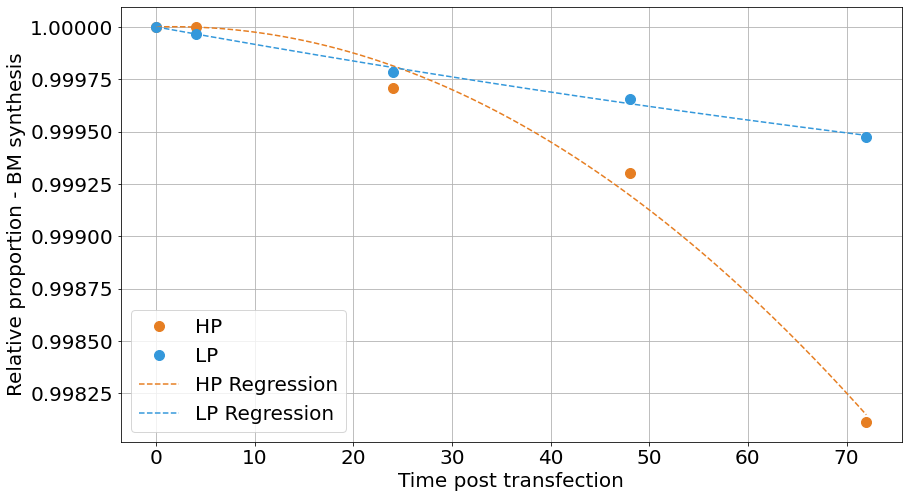

In [31]:
x_range = np.linspace(timepoints.min(), timepoints.max(), 500)

plt.figure(figsize=(14,8))

# Plot the original data points
plt.plot(timepoints, hp_alphas, 'o', color='#E67E22', label='HP', markersize=10)
plt.plot(timepoints, lp_alphas, 'o', color='#3498DB', label='LP', markersize=10)

# Plot the quadratic functions as regression lines
plt.plot(x_range, hp_func(x_range), '--', color='#E67E22', label='HP Regression')
plt.plot(x_range, lp_func(x_range), '--', color='#3498DB', label='LP Regression')

plt.xlabel('Time post transfection', fontsize=20)
plt.ylabel('Relative proportion - BM synthesis', fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/home/users/lzehetner/data/hek/plots/alphas_hp_lp_prod.png')
plt.show()

In [1287]:
###############################
##### Production envelope #####
###############################

In [64]:
def calc_4_pareto(model, factor):
    model.objective = "MAR13082"
    max_biomass = model.optimize().objective_value
    model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * factor
    model.objective = "MAR_SINK"
    max_prod = model.optimize().objective_value
    
    return max_prod

In [ ]:
## paired plots

In [65]:
factors = [0.70, 0.733333, 0.766666, 0.8, 0.833333, 0.866666, 0.9, 0.933333, 0.966666, 1]

prod_rates_hp_4 = []
for factor in factors:
    a = calc_4_pareto(hp_tr_4_model, factor)
    prod_rates_hp_4.append(a)
    
prod_rates_hp_24 = []
for factor in factors:
    a = calc_4_pareto(hp_tr_24_model, factor)
    prod_rates_hp_24.append(a)
    
prod_rates_hp_48 = []
for factor in factors:
    a = calc_4_pareto(hp_tr_48_model, factor)
    prod_rates_hp_48.append(a)
    
prod_rates_hp_72 = []
for factor in factors:
    a = calc_4_pareto(hp_tr_72_model, factor)
    prod_rates_hp_72.append(a)
    
prod_rates_lp_4 = []
for factor in factors:
    a = calc_4_pareto(lp_tr_4_model, factor)
    prod_rates_lp_4.append(a)

prod_rates_lp_24 = []
for factor in factors:
    a = calc_4_pareto(lp_tr_24_model, factor)
    prod_rates_lp_24.append(a)
    
prod_rates_lp_48 = []
for factor in factors:
    a = calc_4_pareto(lp_tr_48_model, factor)
    prod_rates_lp_48.append(a)

prod_rates_lp_72 = []
for factor in factors:
    a = calc_4_pareto(lp_tr_72_model, factor)
    prod_rates_lp_72.append(a)

/home/users/lzehetner/.conda/envs/HEK_human1/lib/python3.7/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [66]:
print(prod_rates_hp_4)
print(prod_rates_hp_24)
print(prod_rates_hp_48)
print(prod_rates_hp_72)
print(prod_rates_lp_4)
print(prod_rates_lp_24)
print(prod_rates_lp_48)
print(prod_rates_lp_72)


[5.857886451463401e-07, 5.320151057801056e-07, 4.782415664138446e-07, 4.244664138252804e-07, 3.706928744590372e-07, 3.1691933509278635e-07, 2.631441825042215e-07, 1.8110855338783686e-07, 9.055563500127789e-08, 0.0]
[3.232055926358995e-07, 2.933041085450814e-07, 2.6340262445426285e-07, 2.3350024330995133e-07, 2.0359875921913327e-07, 1.7369727512831457e-07, 1.4379489398400318e-07, 1.1389340989318484e-07, 7.47977274172204e-08, 0.0]
[2.0687463314075342e-07, 1.8820424710367737e-07, 1.6953386106660137e-07, 1.5086291491234308e-07, 1.3219252887526716e-07, 1.1352214283819109e-07, 9.485119668393292e-08, 7.6180810646857e-08, 5.7510424609780944e-08, 0.0]
[1.0917215164376068e-07, 9.704203387462455e-08, 8.491191610548342e-08, 7.278143442917385e-08, 6.065131666003609e-08, 4.852119889089714e-08, 3.639071721458799e-08, 2.4260599445448283e-08, 1.2130481676310371e-08, 0.0]
[5.824607260606366e-07, 5.466373129908288e-07, 5.108138999210176e-07, 4.7498941213806735e-07, 4.052275913302059e-07, 3.24183045608438

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Generate 10 datasets with different values
#np.random.seed(42)  # For reproducibility

# maximum growth rates
hp_04 = 0.016142
hp_24 = 0.008976
hp_48 = 0.005187
hp_72 = 0.003370
lp_04 = 0.014447
lp_24 = 0.008157
lp_48 = 0.004544
lp_72 = 0.002520

x_hp_real = [hp_04, hp_24, hp_48, hp_72]

y_hp_real = [2.579968997537206e-12, 8.969256348647372e-10, 1.2450694547309147e-09, 6.866444489884284e-10]

x_lp_real = [lp_04, lp_24, lp_48, lp_72]

y_lp_real = [8.210923856649458e-11, 2.949787086182193e-10, 1.6945932319989714e-10, 1.4283849230822598e-10]

x_hp_04 = [hp_04 * 0.7, hp_04 * 0.7333333, hp_04 * 0.766666, 
           hp_04 * 0.8, hp_04 * 0.8333333, hp_04 * 0.866666,
           hp_04 * 0.9, hp_04 * 0.9333333, hp_04 * 0.966666]

y_hp_04 = [5.857886451463401e-07, 5.320151057801056e-07, 4.782415664138446e-07, 
           4.244664138252804e-07, 3.706928744590372e-07, 3.1691933509278635e-07, 
           2.631441825042215e-07, 1.8110855338783686e-07, 9.055563500127789e-08]

x_lp_04 = [lp_04 * 0.7, lp_04 * 0.7333333, lp_04 * 0.766666, 
           lp_04 * 0.8, lp_04 * 0.8333333, lp_04 * 0.866666,
           lp_04 * 0.9, lp_04 * 0.9333333, lp_04 * 0.966666]

y_lp_04 = [5.824607260606366e-07, 5.466373129908288e-07, 5.108138999210176e-07, 
           4.7498941213806735e-07, 4.052275913302059e-07, 3.241830456084388e-07, 
           2.431360685259867e-07, 1.6209152280421951e-07, 8.104697708245213e-08
           ]

x_hp_24 = [hp_24 * 0.7, hp_24 * 0.7333333, hp_24 * 0.766666, 
           hp_24 * 0.8, hp_24 * 0.8333333, hp_24 * 0.866666,
           hp_24 * 0.9, hp_24 * 0.9333333, hp_24 * 0.966666]

y_hp_24 = [3.232055926358995e-07, 2.933041085450814e-07, 2.6340262445426285e-07, 
           2.3350024330995133e-07, 2.0359875921913327e-07, 1.7369727512831457e-07, 
           1.4379489398400318e-07, 1.1389340989318484e-07, 7.47977274172204e-08]

x_lp_24 = [lp_24 * 0.7, lp_24 * 0.7333333, lp_24 * 0.766666, 
           lp_24 * 0.8, lp_24 * 0.8333333, lp_24 * 0.866666,
           lp_24 * 0.9, lp_24 * 0.9333333, lp_24 * 0.966666]

y_lp_24 = [3.5684638389780736e-07, 3.296736048821755e-07, 3.025008258665439e-07,
           2.7455128401758925e-07, 2.2879319426679742e-07, 1.8303510451600626e-07, 
           1.3727564200879492e-07, 9.151755225800274e-08, 4.575946250721169e-08]

x_hp_48 = [hp_48 * 0.7, hp_48 * 0.7333333, hp_48 * 0.766666, 
           hp_48 * 0.8, hp_48 * 0.8333333, hp_48 * 0.866666,
           hp_48 * 0.9, hp_48 * 0.9333333, hp_48 * 0.966666]

y_hp_48 = [2.0687463314075342e-07, 1.8820424710367737e-07, 1.6953386106660137e-07, 
           1.5086291491234308e-07, 1.3219252887526716e-07, 1.1352214283819109e-07, 
           9.485119668393292e-08, 7.6180810646857e-08, 5.7510424609780944e-08]

x_lp_48 = [lp_48 * 0.7, lp_48 * 0.7333333, lp_48 * 0.766666, 
           lp_48 * 0.8, lp_48 * 0.8333333, lp_48 * 0.866666,
           lp_48 * 0.9, lp_48 * 0.9333333, lp_48 * 0.966666]

y_lp_48 = [1.4721279610445892e-07, 1.3085598232928967e-07, 1.1449916855412469e-07, 
           9.814186406963854e-08, 8.178505029447172e-08, 6.542823651930565e-08, 
           4.9070932034819805e-08, 3.2714118259653016e-08, 1.635730448448796e-08]

x_hp_72 = [hp_72 * 0.7, hp_72 * 0.7333333, hp_72 * 0.766666, 
           hp_72 * 0.8, hp_72 * 0.8333333, hp_72 * 0.866666,
           hp_72 * 0.9, hp_72 * 0.9333333, hp_72 * 0.966666]

y_hp_72 = [1.0917215164376068e-07, 9.704203387462455e-08, 8.491191610548342e-08, 
           7.278143442917385e-08, 6.065131666003609e-08, 4.852119889089714e-08, 
           3.639071721458799e-08, 2.4260599445448283e-08, 1.2130481676310371e-08]

x_lp_72 = [lp_72 * 0.7, lp_72 * 0.7333333, lp_72 * 0.766666, 
           lp_72 * 0.8, lp_72 * 0.8333333, lp_72 * 0.866666,
           lp_72 * 0.9, lp_72 * 0.9333333, lp_72 * 0.966666]

y_lp_72 = [8.16416620141057e-08, 7.257045694771833e-08, 6.349925188133114e-08, 
           5.442777467607043e-08, 4.535656960968319e-08, 3.6285364543295847e-08, 
           2.7213887338035227e-08, 1.814268227164799e-08, 9.07147720526068e-09]

/home/users/lzehetner/.conda/envs/HEK_human1/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.


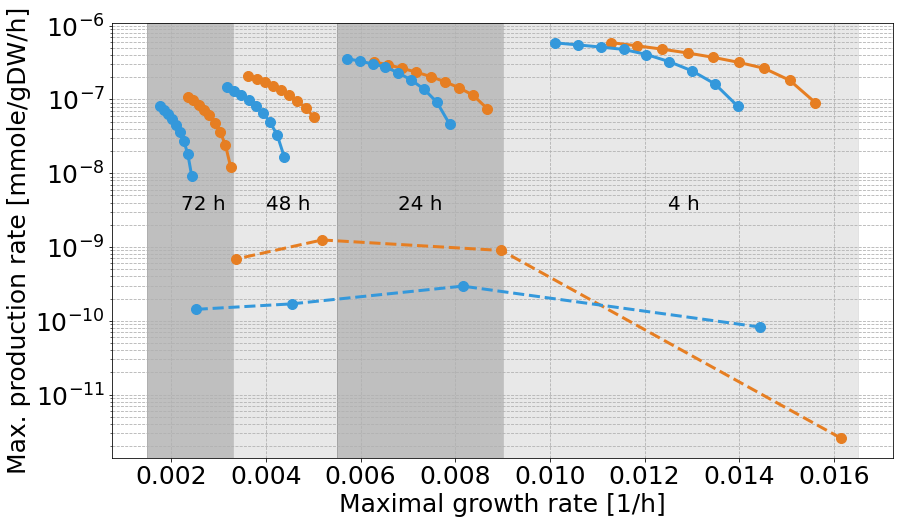

In [57]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Dictionary to hold the datasets
datasets = {
    "x_hp_real": x_hp_real, "y_hp_real": y_hp_real,
    "x_lp_real": x_lp_real, "y_lp_real": y_lp_real,
    "x_hp_04": x_hp_04, "y_hp_04": y_hp_04,
    "x_lp_04": x_lp_04, "y_lp_04": y_lp_04,
    "x_hp_24": x_hp_24, "y_hp_24": y_hp_24,
    "x_lp_24": x_lp_24, "y_lp_24": y_lp_24,
    "x_hp_48": x_hp_48, "y_hp_48": y_hp_48,
    "x_lp_48": x_lp_48, "y_lp_48": y_lp_48,
    "x_hp_72": x_hp_72, "y_hp_72": y_hp_72,
    "x_lp_72": x_lp_72, "y_lp_72": y_lp_72
}

# Plot all datasets
for i, (key_x, key_y) in enumerate(zip(list(datasets.keys())[::2], list(datasets.keys())[1::2])):
    # Check if the dataset contains '_real' in its name for dashed line style
    linestyle = '--' if '_real' in key_x else '-'
    
    # Assign color based on high producer (hp) or low producer (lp)
    color = "#E67E22" if 'hp' in key_x else "#3498DB"
    
    # Plot the dataset with appropriate linestyle and color
    ax.plot(datasets[key_x], datasets[key_y], 'o-', color=color, linestyle=linestyle, 
            markersize=10, linewidth=3, label=key_x)

# Set log scale for y-axis
ax.set_yscale('log')

# Labeling axes
plt.xlabel('Maximal growth rate [1/h]', fontsize=25)  # Set x-axis label font size
plt.ylabel('Max. production rate [mmole/gDW/h]', fontsize=25)  # Set y-axis label font size
plt.xticks(fontsize=25)  # Increase the font size of x-ticks
plt.yticks(fontsize=25)  # Increase the font size of y-ticks

# Adding vertical shaded regions to mimic the original image
ax.axvspan(0.0015, 0.0033, color='gray', alpha=0.5)
ax.axvspan(0.0033, 0.0055, color='lightgray', alpha=0.5)
ax.axvspan(0.0055, 0.009, color='gray', alpha=0.5)
ax.axvspan(0.009, 0.0165, color='lightgray', alpha=0.5)

# Adding text annotations
ax.text(0.0022, 3.8e-9, '72 h', rotation=0, verticalalignment='center', color='black', fontsize = 20)
ax.text(0.004, 3.8e-9, '48 h', rotation=0, verticalalignment='center', color='black', fontsize = 20)
ax.text(0.0068, 3.8e-9, '24 h', rotation=0, verticalalignment='center', color='black', fontsize = 20)
ax.text(0.0125, 3.8e-9, '4 h', rotation=0, verticalalignment='center', color='black', fontsize = 20)

# Show legend
#ax.legend()

# Show grid for better visualization
ax.grid(True, which="both", ls="--")

plt.savefig('/home/users/lzehetner/data/hek/plots/prod_env.png')

# Display the plot
plt.show()

In [ ]:
######################################
#### flux distribution using pFBA ####
######################################

In [27]:
from cobra.flux_analysis import pfba

In [30]:
hp_alphas = np.array([0.9999990503, 0.9997094664093564, 0.9993020784457456, 0.9981131329593219])
lp_alphas = np.array([0.9999662291, 0.9997851194106243, 0.9996546645515525, 0.9994751264656386])

In [ ]:
## transfected

In [31]:
tr_models = [hp_tr_4_model, hp_tr_24_model, hp_tr_48_model, hp_tr_72_model, 
          lp_tr_4_model, lp_tr_24_model, lp_tr_48_model, lp_tr_72_model
         ]
tr_model_ids = [hp_tr_4, hp_tr_24, hp_tr_48, hp_tr_72, 
          lp_tr_4, lp_tr_24, lp_tr_48, lp_tr_72
              ]
#alpha_values = [0.9999936, 0.9997094, 0.9993020, 0.9981131,
#         0.999972, 0.999785, 0.9996546, 0.9994751]
alphas_array = np.concatenate((hp_alphas, lp_alphas))

# Convert the merged array to a list
alpha_values = alphas_array.tolist()

In [33]:
def perform_pfba(model, alpha):
    """ Perform flux variability analysis on a given model using a specific alpha multiplier. """
    model.objective = 'MAR13082'
    max_biomass = model.optimize().objective_value
    model.reactions.get_by_id("MAR13082").lower_bound = max_biomass * alpha
    print(max_biomass)
    model.objective = "MAR_SINK"
    max_prod = model.optimize().objective_value
    model.reactions.get_by_id("MAR_SINK").lower_bound = max_prod
    print(max_prod)
    model.objective = "MAR13082"
    model.reactions.get_by_id("MAR13082").lower_bound = 0.0
    pfba_results = pfba(model)
#    flux_distribution = model.optimize()
    return pd.Series(pfba_results.fluxes)

def aggregate_fluxes_tr(models, model_names, alphas):
    """
    Perform FBA on a list of models with corresponding alpha multipliers and aggregate the flux distributions into a single DataFrame.
    
    Args:
    models (list of cobra.Model): List of COBRApy model objects.
    model_names (list of str): List of model names corresponding to each model.
    alphas (list of float): List of alpha multipliers corresponding to each model.

    Returns:
    DataFrame with reaction IDs as rows and models as columns, including 0.0 for missing reactions.
    """
    # Dictionary to hold the series of fluxes for each model
    all_fluxes = {}
    
    # Iterate over models, names, and alphas simultaneously
    for model, name, alpha in zip(models, model_names, alphas):
        fluxes = perform_pfba(model, alpha)
        all_fluxes[name] = fluxes

    # Create a DataFrame from the dictionary, filling missing values with 0.0
    flux_df = pd.DataFrame(all_fluxes).fillna(0.0)
    return flux_df

In [34]:
tr_flux_distribution = aggregate_fluxes_tr(tr_models, tr_model_ids, alpha_values)

0.01614197458111814
3.1389622773154525e-12
0.00897595735412287
8.969256348760164e-10
0.005186897465820183
1.3806710785139192e-09
0.0033699183826140827
6.866444489884053e-10
0.014447010878151872
9.989957358923507e-11
0.008156842814106663
3.588907621521892e-10
0.00454415434961138
1.694593231999096e-10
0.002520109143825086
1.4283849230829934e-10


In [36]:
fd_tr = tr_flux_distribution
tr_fluxes = fd_tr.reset_index()
tr_fluxes.columns = ["reaction_id", "hp_tr_4", "hp_tr_24", "hp_tr_48", "hp_tr_72", 
          "lp_tr_4", "lp_tr_24", "lp_tr_48", "lp_tr_72"
              ]

In [39]:
tr_fluxes.to_csv('/home/users/lzehetner/data/hek/flux_distribution_tr_pfba.csv', index=False)

In [ ]:
## mock

In [40]:
mo_models = [hp_mo_4_model, hp_mo_24_model, hp_mo_48_model, hp_mo_72_model, 
         lp_mo_4_model, lp_mo_24_model, lp_mo_48_model, lp_mo_72_model
         ]
mo_model_ids = [hp_mo_4, hp_mo_24, hp_mo_48, hp_mo_72, 
             lp_mo_4, lp_mo_24, lp_mo_48, lp_mo_72,
              ]

In [41]:
def perform_pfba(model):
    """ Perform flux variability analysis on a given model. """
    model.objective = 'MAR13082'
    max_biomass = model.optimize().objective_value
    print(max_biomass)
    pfba_results = pfba(model)
    return pd.Series(pfba_results.fluxes)

def aggregate_fluxes_mo(models, model_names):
    """
    Perform FBA on a list of models with corresponding alpha multipliers and aggregate the flux distributions into a single DataFrame.
    
    Args:
    models (list of cobra.Model): List of COBRApy model objects.
    model_names (list of str): List of model names corresponding to each model.
    alphas (list of float): List of alpha multipliers corresponding to each model.

    Returns:
    DataFrame with reaction IDs as rows and models as columns, including 0.0 for missing reactions.
    """
    # Dictionary to hold the series of fluxes for each model
    all_fluxes = {}
    
    # Iterate over models, names, and alphas simultaneously
    for model, name in zip(models, model_names):
        fluxes = perform_pfba(model)
        all_fluxes[name] = fluxes

    # Create a DataFrame from the dictionary, filling missing values with 0.0
    flux_df = pd.DataFrame(all_fluxes).fillna(0.0)
    return flux_df

In [42]:
mo_flux_distribution = aggregate_fluxes_mo(mo_models, mo_model_ids)

0.018273388694063097
0.008567985705474077
0.0045438993839883295
0.00245141366987891
0.010674391599446515
0.006967827612437361
0.0046398361444218135
0.0025172595224458596


In [44]:
fd_mo = mo_flux_distribution
mo_fluxes = fd_mo.reset_index()
mo_fluxes.columns = ["reaction_id", "hp_mo_4", "hp_mo_24", "hp_mo_48", "hp_mo_72", 
          "lp_mo_4", "lp_mo_24", "lp_mo_48", "lp_mo_72"
              ]

In [46]:
mo_fluxes.to_csv('/home/users/lzehetner/data/hek/flux_distribution_mo_pfba.csv', index=False)

In [47]:
# Setting reaction_id as the index if not already set
if tr_fluxes.columns[0] == 'reaction_id':
    tr_fluxes.set_index('reaction_id', inplace=True)
if mo_fluxes.columns[0] == 'reaction_id':
    mo_fluxes.set_index('reaction_id', inplace=True)

# Merging the DataFrames
merged_df = pd.merge(tr_fluxes, mo_fluxes, left_index=True, right_index=True, how='outer')

# Filling NA values with 0.0
merged_df.fillna(0.0, inplace=True)

In [49]:
merged_df.to_csv('/home/users/lzehetner/data/hek/flux_distribution_combined_pfba.csv', index=True)

In [1074]:
###############################################################################
## Analyze flux distribution between models, when fluxes are different by x% ##
###############################################################################

In [50]:
def enrichment(df, column1, column2, percentage_threshold):
    
    # Calculate the percentage change and filter for significant changes
    df['percent_change'] = 100 * (df[column1] - df[column2]) / abs(df[column2])

    # Identify upregulated reactions (flux in model1 is at least 10% higher than in model2)
    upregulated_reactions = df[df['percent_change'] >= percentage_threshold]

    upregulated_reaction_ids = upregulated_reactions.index.tolist()
    
    # Identify downregulated reactions (flux in model1 is at least 10% lower than in model2)
    downregulated_reactions = df[df['percent_change'] <= -percentage_threshold]

    downregulated_reaction_ids = downregulated_reactions.index.tolist()
    
    print("Upregulated reactions:")
    print(len(upregulated_reactions))

    print("Downregulated reactions:")
    print(len(downregulated_reactions))
    
    return upregulated_reaction_ids, downregulated_reaction_ids

In [ ]:
#---Condition---#
### HP vs LP ###
#---------------#

In [67]:
hp_lp_tr = enrichment(merged_df, "lp_tr_4", "hp_tr_4", 50)
hp_lp_tr_4_up = hp_lp_tr[0]
hp_lp_tr_4_down = hp_lp_tr[1]

Upregulated reactions:
130
Downregulated reactions:
155


In [68]:
hp_lp_tr = enrichment(merged_df, "lp_tr_24", "hp_tr_24", 50)
hp_lp_tr_24_up = hp_lp_tr[0]
hp_lp_tr_24_down = hp_lp_tr[1]

Upregulated reactions:
100
Downregulated reactions:
148


In [69]:
hp_lp_tr = enrichment(merged_df, "lp_tr_48", "hp_tr_48", 50)
hp_lp_tr_48_up = hp_lp_tr[0]
hp_lp_tr_48_down = hp_lp_tr[1]

Upregulated reactions:
95
Downregulated reactions:
79


In [70]:
hp_lp_tr = enrichment(merged_df, "lp_tr_72", "hp_tr_72", 50)
hp_lp_tr_72_up = hp_lp_tr[0]
hp_lp_tr_72_down = hp_lp_tr[1]

Upregulated reactions:
73
Downregulated reactions:
70


In [71]:
set1 = set(hp_lp_tr_4_up)
set2 = set(hp_lp_tr_24_up)
set3 = set(hp_lp_tr_48_up)
set4 = set(hp_lp_tr_72_up)

common_elements = set1 & set2 & set3 # & set4

common_elements_list = list(common_elements)

common_elements_list

['MAR04404',
 'MAR04501',
 'MAR05481',
 'MAR04565',
 'MAR08992',
 'MAR09012',
 'MAR09061',
 'MAR05330',
 'MAR05517']

In [72]:
common_elements = set1 & set2 & set3 & set4

common_elements_list = list(common_elements)

common_elements_list

['MAR04404', 'MAR04501', 'MAR04565', 'MAR08992', 'MAR09061', 'MAR05330']

In [73]:
set1 = set(hp_lp_tr_4_down)
set2 = set(hp_lp_tr_24_down)
set3 = set(hp_lp_tr_48_down)
set4 = set(hp_lp_tr_72_down)

common_elements = set1 & set2 & set3  & set4

common_elements_list = list(common_elements)

common_elements_list

['MAR09071', 'MAR05127', 'MAR09068', 'MAR09031', 'MAR04875', 'MAR03806']

In [74]:
common_elements = set1 & set2 & set3 # & set4

common_elements_list = list(common_elements)

common_elements_list

['MAR00710',
 'MAR09001',
 'MAR09071',
 'MAR05127',
 'MAR09068',
 'MAR09031',
 'MAR04304',
 'MAR04875',
 'MAR03806']

In [96]:
hp_lp_mo = enrichment(merged_df, "lp_mo_4", "hp_mo_4", 50)
hp_lp_mo_4_up = hp_lp_mo[0]
hp_lp_mo_4_down = hp_lp_mo[1]

Upregulated reactions:
163
Downregulated reactions:
178


In [97]:
hp_lp_mo = enrichment(merged_df, "lp_mo_24", "hp_mo_24", 50)
hp_lp_mo_24_up = hp_lp_mo[0]
hp_lp_mo_24_down = hp_lp_mo[1]

Upregulated reactions:
92
Downregulated reactions:
113


In [98]:
hp_lp_mo = enrichment(merged_df, "lp_mo_48", "hp_mo_48", 50)
hp_lp_mo_48_up = hp_lp_mo[0]
hp_lp_mo_48_down = hp_lp_mo[1]

Upregulated reactions:
89
Downregulated reactions:
78


In [99]:
hp_lp_mo = enrichment(merged_df, "lp_mo_72", "hp_mo_72", 50)
hp_lp_mo_72_up = hp_lp_mo[0]
hp_lp_mo_72_down = hp_lp_mo[1]

Upregulated reactions:
94
Downregulated reactions:
85


In [100]:
set1 = set(hp_lp_mo_4_up)
set2 = set(hp_lp_mo_24_up)
set3 = set(hp_lp_mo_48_up)
set4 = set(hp_lp_mo_72_up)

common_elements = set1 & set2 & set3 # & set4

common_elements_list = list(common_elements)

common_elements_list

['MAR09061', 'MAR05330', 'MAR05517', 'MAR00101', 'MAR04312', 'MAR09685']

In [101]:
common_elements = set1 & set2 & set3 & set4

common_elements_list = list(common_elements)

common_elements_list

['MAR05330']

In [102]:
set1 = set(hp_lp_mo_4_down)
set2 = set(hp_lp_mo_24_down)
set3 = set(hp_lp_mo_48_down)
set4 = set(hp_lp_mo_72_down)

common_elements = set1 & set2 & set3 # & set4

common_elements_list = list(common_elements)

common_elements_list

['MAR09071', 'MAR04316', 'MAR09068', 'MAR09031', 'MAR04875', 'MAR03806']

In [103]:
common_elements = set1 & set2 & set3 & set4

common_elements_list = list(common_elements)

common_elements_list

['MAR09031', 'MAR04875', 'MAR09071']